# Предсказание наличия заболевания COVID-19 на основе симптомов

## Подготовка и исследование данных

In [1]:
#!pip install ydata_profiling
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from ydata_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [3]:
warnings.filterwarnings('ignore') # скроем лишние предупреждения

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('covid_dataset.csv')
df.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes


In [6]:
# приводим названия признаков в корректный вид
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.rename(columns={'fatigue_': 'fatigue', 'gastrointestinal_': 'gastrointestinal'}, inplace=True)
df.head()

,breathing_problem,fever,dry_cough,sore_throat,running_nose,asthma,chronic_lung_disease,headache,heart_disease,diabetes,hyper_tension,fatigue,gastrointestinal,abroad_travel,contact_with_covid_patient,attended_large_gathering,visited_public_exposed_places,family_working_in_public_exposed_places,wearing_masks,sanitization_from_market,covid-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,No,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,No,No,No,Yes


In [7]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# удаляем признаки, непосредственно несвязанные с заболеваемостью COVID-19 (они связаны с тяжестью течения) и неиформативные признаки
df = df.drop('asthma',axis=1)
df = df.drop('chronic_lung_disease',axis=1)
df = df.drop('headache',axis=1)
df = df.drop('heart_disease',axis=1)
df = df.drop('diabetes',axis=1)
df = df.drop('gastrointestinal',axis=1)
df = df.drop('wearing_masks',axis=1)
df = df.drop('sanitization_from_market',axis=1)

In [9]:
le = LabelEncoder()
df = df.apply(le.fit_transform).astype(int)

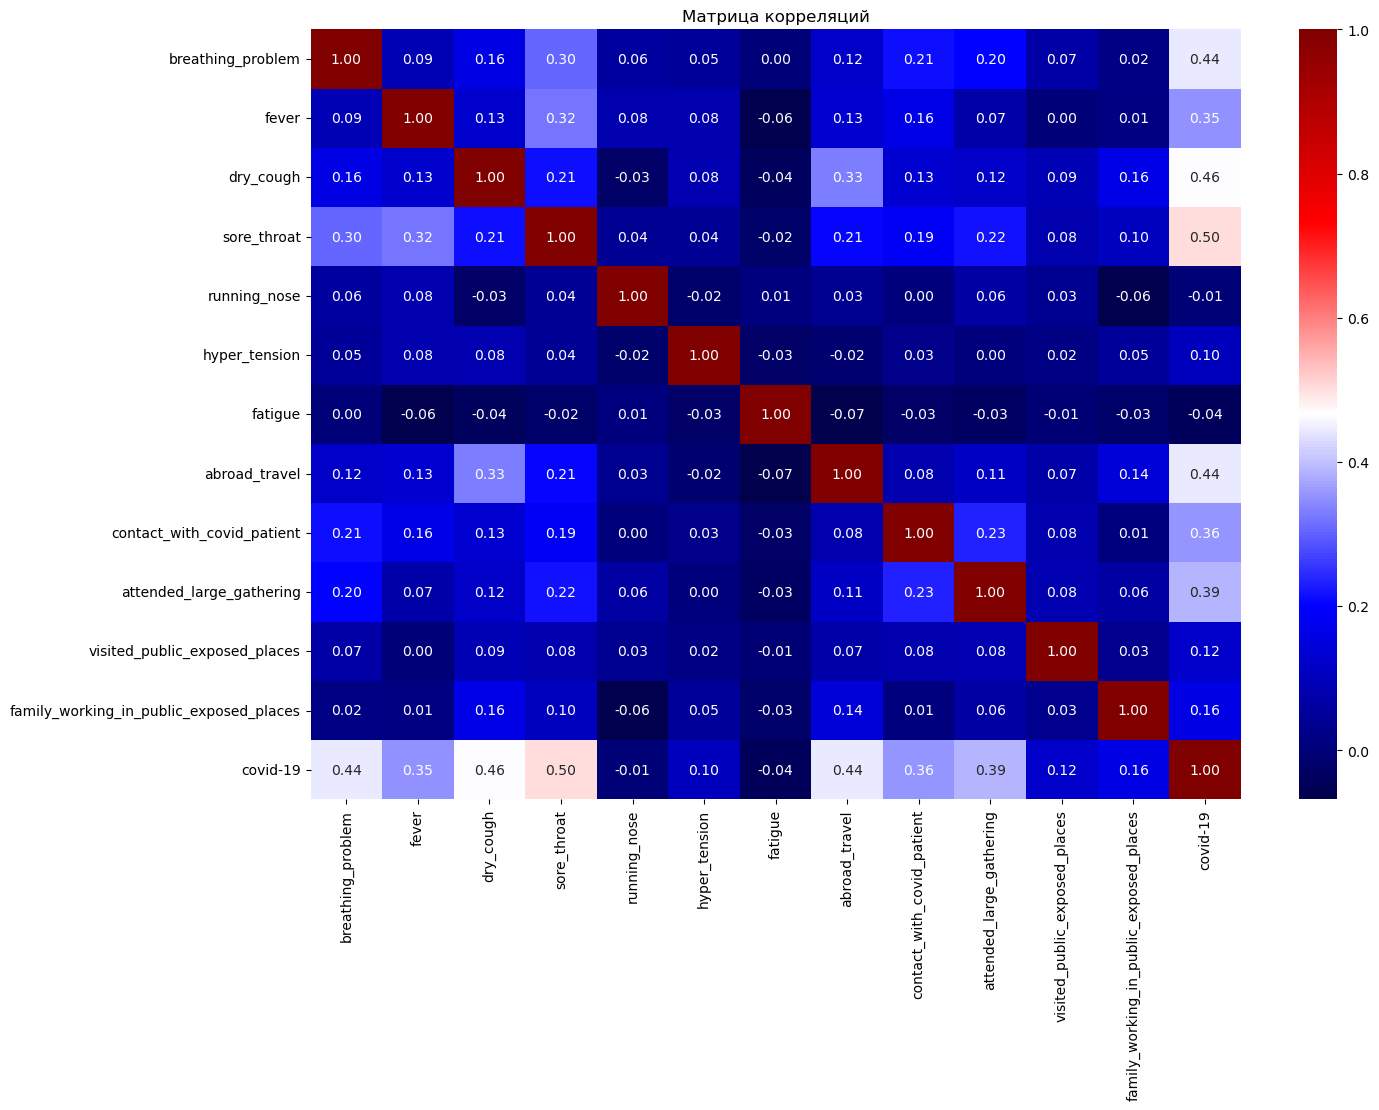

In [10]:
# матрица корреляций в виде тепловой карты
plt.figure(figsize=(15, 10)) # визуализируем данные
sns.heatmap(df.corr(), annot=True, cmap='seismic', fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

**Промежуточный итог:** в датасете 5343 строки, 21 столбец. Пропуски отсутсвуют. Присутсвуют яные дубликаты, однако, учитывая, что это данные отдельных пациентов, удалению они не подлежат. Проведена предобработка данных. Названия столбцов привидены в корректный вид. Удалены признаки не относящиеся к оценке фактора заболеваемости пациента (они имеют отношение к тяжести течения, которое в данной работе не оценивается). Наибольшая корреляция наблюдается между целевым признаком `covid-19` и признаками `sore_throat`, `dry_cough`, `breathing_problem`, `abroad_travel`.

## Исследование различных моделей машинного обучения

In [11]:
# формирование выборок
X = df.drop('covid-19', axis=1)
y = df['covid-19']

In [12]:
RANDOM_STATE = 42 # создание константы RANDOM_STATE
# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
    )

In [13]:
RANDOM_STATE = 42 # создание константы RANDOM_STATE
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

### LogisticRegression

In [14]:
model = LogisticRegression(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_logr1 = accuracy_score(y_test, y_pred)
f1_logr1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy на тестовой выборке:", acc_logr1)
print("F1 score на тестовой выборке:", f1_logr1)

Accuracy на тестовой выборке: 0.9727740986019132


Оценим accuracy при изменении гиперпараметров. Для этого вольпользуемся GridSearch (для этой и последующих моеделей).

In [15]:
model_logr = LogisticRegression(random_state=RANDOM_STATE)

# Определяем сетку гиперпараметров
param_grid = {
    'C': [0.1, 1.0, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
}

# GridSearchCV
grid_search_logr = GridSearchCV(
    estimator=model_logr,
    param_grid=param_grid,
    scoring='accuracy',  # Оцениваем по accuracy
    cv=5                # 5-кратная перекрестная проверка
)
grid_search_logr.fit(X_train, y_train)

# Лучшие параметры
print('Лучшие параметры:', grid_search_logr.best_params_)
print('Лучший результат cross-validation (accuracy):', grid_search_logr.best_score_)

Лучшие параметры: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Лучший результат cross-validation (accuracy): 0.9683435582822085


In [16]:
model_logr = grid_search_logr.best_estimator_
y_pred = model_logr.predict(X_test)

acc_logr2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_logr2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.9727740986019132
Отчет классификации:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93       259
           1       0.97      0.99      0.98      1100

    accuracy                           0.97      1359
   macro avg       0.97      0.94      0.95      1359
weighted avg       0.97      0.97      0.97      1359



### DecisionTreeClassifier

In [17]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_dtc1 = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", acc_dtc1)

Accuracy на тестовой выборке: 0.9793966151582045


In [18]:
model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)

#Определяем сетку гиперпараметров
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],  # Критерий разбиения
    'max_features': [None, 'sqrt', 'log2']
}

# Настраиваем Grid Search
grid_search_dtc = GridSearchCV(
    estimator=model_dtc,
    param_grid=param_grid,
    scoring='accuracy',  # Оцениваем по метрике accuracy
    cv=5)                # 5-кратная перекрестная проверка

# Запускаем подбор гиперпараметров
grid_search_dtc.fit(X_train, y_train)

# Выводим лучшие параметры и лучшее значение метрики
print("Лучшие параметры:", grid_search_dtc.best_params_)
print("Лучший результат cross-validation (accuracy):", grid_search_dtc.best_score_)

Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший результат cross-validation (accuracy): 0.9766871165644172


In [19]:
# Применяем модель с подобранными параметрами на тестовой выборке
model_dtc = grid_search_dtc.best_estimator_
y_pred = model_dtc.predict(X_test)

# Оцениваем качество на тестовой выборке
acc_dtc2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_dtc2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.9793966151582045
Отчет классификации:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       259
           1       0.99      0.99      0.99      1100

    accuracy                           0.98      1359
   macro avg       0.97      0.96      0.97      1359
weighted avg       0.98      0.98      0.98      1359



### RandomForestClassifier

In [20]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_rfc1 = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", acc_rfc1)

Accuracy на тестовой выборке: 0.9793966151582045


In [21]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

# Определяем сетку гиперпараметров
param_grid = {
    'n_estimators': [10, 30, 50],            # Количество деревьев в ансамбле
    'max_depth': [None, 5, 10, 20],          # Максимальная глубина каждого дерева
    'min_samples_split': [2, 5, 10],         # Минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],           # Минимальное количество образцов в листе
    'max_features': ['sqrt', 'log2', None],  # Число признаков для каждого узла
    'criterion': ['gini', 'entropy']         # Критерий разбиения узлов
}

# Настраиваем Grid Search
grid_search_rfc = GridSearchCV(
    estimator=model_rfc,
    param_grid=param_grid,
    scoring='accuracy',  # Используем метрику accuracy
    cv=5)                # 5-кратная перекрестная проверка

# Запускаем подбор гиперпараметров
grid_search_rfc.fit(X_train, y_train)

# Выводим лучшие параметры и лучшее значение метрики
print("Лучшие параметры:", grid_search_rfc.best_params_)
print("Лучший результат cross-validation (accuracy):", grid_search_rfc.best_score_)

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Лучший результат cross-validation (accuracy): 0.9791411042944785


In [22]:
# Применяем модель с подобранными параметрами на тестовой выборке
model_rfc = grid_search_rfc.best_estimator_
y_pred = model_rfc.predict(X_test)

# Оцениваем качество на тестовой выборке
acc_rfc2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_rfc2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.9793966151582045
Отчет классификации:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       259
           1       0.99      0.99      0.99      1100

    accuracy                           0.98      1359
   macro avg       0.97      0.96      0.97      1359
weighted avg       0.98      0.98      0.98      1359



### Support Vector Machine

In [23]:
model = SVC(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_svc1 = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", acc_svc1)

Accuracy на тестовой выборке: 0.9793966151582045


In [24]:
model_svc = SVC(random_state=RANDOM_STATE)

# Определяем сетку гиперпараметров
param_grid = {
    'C': [0.1, 1, 10, 100],           # Параметр регуляризации
    'kernel': ['linear', 'rbf'],      # Тип ядра (линейное, радиальное)
    'gamma': ['scale', 'auto'],       # Параметр ядра RBF
    'degree': [2, 3, 4]               # Степень полинома (если kernel='poly')
}

# Настраиваем Grid Search
grid_search_svc = GridSearchCV(
    estimator=model_svc,
    param_grid=param_grid,
    scoring='accuracy',  # Используем метрику accuracy
    cv=5)                # 5-кратная перекрестная проверка

# Запускаем подбор гиперпараметров
grid_search_svc.fit(X_train, y_train)

# Выводим лучшие параметры и лучшее значение метрики
print("Лучшие параметры:", grid_search_svc.best_params_)
print("Лучший результат cross-validation (accuracy):", grid_search_svc.best_score_)

Лучшие параметры: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Лучший результат cross-validation (accuracy): 0.9766871165644172


In [25]:
# Применяем модель с подобранными параметрами на тестовой выборке
model_svc = grid_search_svc.best_estimator_
y_pred = model_svc.predict(X_test)

# Оцениваем качество на тестовой выборке
acc_svc2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_svc2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.9793966151582045
Отчет классификации:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       259
           1       0.99      0.99      0.99      1100

    accuracy                           0.98      1359
   macro avg       0.97      0.96      0.97      1359
weighted avg       0.98      0.98      0.98      1359



### Naive Bayes

In [26]:
model = GaussianNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_nb1 = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", acc_nb1)

Accuracy на тестовой выборке: 0.7608535688005886


In [27]:
model_nb = GaussianNB()

# Определяем сетку гиперпараметров
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Параметр сглаживания для предотвращения деления на 0
}

# Настраиваем Grid Search
grid_search_nb = GridSearchCV(
    estimator=model_nb,
    param_grid=param_grid,
    scoring='accuracy',  # Используем метрику accuracy
    cv=5)                # 5-кратная перекрестная проверка

# Запускаем подбор гиперпараметров
grid_search_nb.fit(X_train, y_train)

# Выводим лучшие параметры и лучшее значение метрики
print("Лучшие параметры:", grid_search_nb.best_params_)
print("Лучший результат cross-validation (accuracy):", grid_search_nb.best_score_)

Лучшие параметры: {'var_smoothing': 1e-05}
Лучший результат cross-validation (accuracy): 0.8773006134969326


In [28]:
# Применяем модель с подобранными параметрами на тестовой выборке
model_nb = grid_search_nb.best_estimator_
y_pred = model_nb.predict(X_test)

# Оцениваем качество на тестовой выборке
acc_nb2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_nb2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.8785871964679912
Отчет классификации:
               precision    recall  f1-score   support

           0       0.61      0.98      0.76       259
           1       1.00      0.85      0.92      1100

    accuracy                           0.88      1359
   macro avg       0.80      0.92      0.84      1359
weighted avg       0.92      0.88      0.89      1359



### XGBClassifier

In [29]:
model = XGBClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_xgb1 = accuracy_score(y_test, y_pred)

print("Accuracy на тестовой выборке:", acc_xgb1)

Accuracy на тестовой выборке: 0.9793966151582045


In [30]:
model_xgb = XGBClassifier(random_state=RANDOM_STATE)

# Определяем сетку гиперпараметров
param_grid = {
    'n_estimators': [10, 30, 50],          # Количество деревьев
    'max_depth': [3, 5, 7],                  # Глубина деревьев
    'learning_rate': [0.01, 0.1, 0.2],       # Темп обучения
    'subsample': [0.8, 0.9, 1.0],             # Доля обучающих данных для каждого дерева
    'colsample_bytree': [0.8, 0.9, 1.0],     # Доля признаков, используемых для каждого дерева
    'gamma': [0, 0.1, 0.2]                   # Параметр, контролирующий разбиение узлов
}

# Настраиваем Grid Search
grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='accuracy',  # Используем метрику accuracy
    cv=5)                # 5-кратная перекрестная проверка

# Запускаем подбор гиперпараметров
grid_search_xgb.fit(X_train, y_train)

# Выводим лучшие параметры и лучшее значение метрики
print("Лучшие параметры:", grid_search_xgb.best_params_)
print("Лучший результат cross-validation (accuracy):", grid_search_xgb.best_score_)

Лучшие параметры: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 30, 'subsample': 0.8}
Лучший результат cross-validation (accuracy): 0.9803680981595091


In [31]:
# Применяем модель с подобранными параметрами на тестовой выборке
model_xgb = grid_search_xgb.best_estimator_
y_pred = model_xgb.predict(X_test)

# Оцениваем качество на тестовой выборке
acc_xgb2 = accuracy_score(y_test, y_pred)
print("Accuracy на тестовой выборке:", acc_xgb2)
print("Отчет классификации:\n", classification_report(y_test, y_pred))

Accuracy на тестовой выборке: 0.9793966151582045
Отчет классификации:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       259
           1       0.99      0.99      0.99      1100

    accuracy                           0.98      1359
   macro avg       0.97      0.96      0.97      1359
weighted avg       0.98      0.98      0.98      1359



## Итоги

In [32]:
results = pd.DataFrame({
    'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier',
              'SVC', 'Naive Bayes',
              'XGBClassifier'],
    'Accuracy_1': [acc_logr1, acc_dtc1, acc_rfc1,
              acc_svc1, acc_nb1, acc_xgb1],
    'Accuracy_2': [acc_logr2, acc_dtc2, acc_rfc2,
              acc_svc2, acc_nb2, acc_xgb2]})

results.sort_values(by='Accuracy_2', ascending=False)

,Модель,Accuracy_1,Accuracy_2
1,DecisionTreeClassifier,0.979397,0.979397
2,RandomForestClassifier,0.979397,0.979397
3,SVC,0.979397,0.979397
5,XGBClassifier,0.979397,0.979397
0,LogisticRegression,0.972774,0.972774
4,Naive Bayes,0.760854,0.878587
